In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd

In [2]:
nwp_path = "gs://solar-pv-nowcasting-data/NWP/UK_Met_Office/UKV_intermediate_version_3.zarr/"
gsp_path = "gs://solar-pv-nowcasting-data/PV/GSP/v5/pv_gsp.zarr"
gsp = xr.open_zarr(gsp_path)
nwp = xr.open_zarr(nwp_path)

In [3]:
def build_datasets_for_prediction_horizon(hour_forecast_horizon: int):
    # select the nwp variables at the prediction horizon
    X = nwp.isel(step=hour_forecast_horizon)
    
    # select the relevant PV target - shift by the prediction horizon
    target = gsp["generation_mw"].where((gsp["datetime_gmt"] >= X.coords["init_time"].values[0] + X.step.values) & (gsp["datetime_gmt"] <= X.coords["init_time"].values[-1] + X.step.values), drop=True)
    target = target.isel(gsp_id=0) 
    
    X = X.chunk({"init_time": 1, "variable": 1})
    # take geospatial mean
    X = X.mean(dim=["x", "y"])
    # interpolate to 1/2 hourly (same resolution as PV target)
    new_times = target.coords["datetime_gmt"].values - X.step.values
    X = X.interp(init_time=new_times, method="cubic")
    
    # compute the transformation - this can take some time
    _X = X.to_array().as_numpy()
    _X = _X.values.reshape(_X.shape[1], _X.shape[2]).T
    
    # compute datetime features
    datetime_features = trigonometric_datetime_transformation(X["init_time"])
    
    # concat
    _X = np.concatenate((_X, datetime_features), axis=1)
    
    return _X, target

# stolen from datapipes

from pandas.core.dtypes.common import is_datetime64_dtype
import numpy.typing as npt
from typing import Union, Tuple

def _trig_transform(values: np.ndarray, period: Union[float, int]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Given a list of values and an upper limit on the values, compute trig decomposition.
    Args:
        values: ndarray of points in the range [0, period]
        period: period of the data
    Returns:
        Decomposition of values into sine and cosine of data with given period
    """

    return np.sin(values * 2 * np.pi / period), np.cos(values * 2 * np.pi / period)


def trigonometric_datetime_transformation(datetimes: npt.ArrayLike) -> np.ndarray:
    """
    Given an iterable of datetimes, returns a trigonometric decomposition on hour, day and month
    Args:
        datetimes: ArrayLike of datetime64 values
    Returns:
        Trigonometric decomposition of datetime into hourly, daily and
        monthly values.
    """
    assert is_datetime64_dtype(datetimes), "Data for Trig Decomposition must be np.datetime64 type"

    datetimes = pd.DatetimeIndex(datetimes)
    hour = datetimes.hour.values.reshape(-1, 1) + (datetimes.minute.values.reshape(-1, 1) / 60)
    day = datetimes.day.values.reshape(-1, 1)
    month = datetimes.month.values.reshape(-1, 1)

    sine_hour, cosine_hour = _trig_transform(hour, 24)
    sine_day, cosine_day = _trig_transform(day, 366)
    sine_month, cosine_month = _trig_transform(month, 12)

    return np.concatenate(
        [sine_month, cosine_month, sine_day, cosine_day, sine_hour, cosine_hour], axis=1
    )

In [4]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
from dataclasses import dataclass

TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]


# optimal hyperparameters from prev trained model

hyperparams = {'objective': 'reg:squarederror',
               'base_score': 0.5,
               'booster': 'gbtree',
               'callbacks': None,
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'enable_categorical': False,
               'eval_metric': None,
               'feature_types': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_cat_to_onehot': 4,
               'max_delta_step': 0,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'monotone_constraints': '()',
               'n_estimators': 1500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'hist',
               'validate_parameters': 1,
               'verbosity': 0
 }


@dataclass
class ExperimentSummary:
    look_ahead_hours: int
    mse_train_loss: float
    mse_test_loss: float
    mae_train_loss: float
    mae_test_loss: float
    feature_importance: pd.DataFrame
    


def run_experiment(forecast_horizon_hours: int):
    _start = time.time()
    X, target = build_datasets_for_prediction_horizon(forecast_horizon_hours)
    design = pd.DataFrame(data=X, columns=list(nwp.coords["variable"].values) + TRIG_DATETIME_FEATURE_NAMES)
    y = pd.DataFrame(data=target.values, columns=["GSP_PV"])
    
    # start with a randomised train/test split before structing a time-series specific one
    n = design.shape[0]
    train_idx = np.random.choice(np.arange(n), int(0.8*n), replace=False)
    test_idx = list(set(np.arange(n)).difference(train_idx))
    X_train, y_train = design.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = design.iloc[test_idx], y.iloc[test_idx]
    
    # fit a vanilla xgboost with basic hyperparameters
    model_xg = XGBRegressor(**hyperparams)
    model_xg.fit(X_train, y_train)
    
    mse_train, mse_test = mean_squared_error(y_train, model_xg.predict(X_train)), mean_squared_error(y_test, model_xg.predict(X_test))
    mae_train, mae_test = mean_absolute_error(y_train, model_xg.predict(X_train)), mean_absolute_error(y_test, model_xg.predict(X_test))
    
    feature_importances = pd.DataFrame.from_dict(model_xg.get_booster().get_score(importance_type='weight'), orient="index").sort_values(by=0, ascending=False)
    
    _end = time.time()
    
    print(f"Completed run for horizon: {forecast_horizon_hours} in {(_end - _start):.2f} seconds.")
    
    output = ExperimentSummary(
        forecast_horizon_hours,
        mse_train,
        mse_test,
        mae_train,
        mae_test,
        feature_importances
    )
    
    return output
    

In [5]:
results = run_experiment(4)

Completed run for horizon: 4 in 614.98 seconds.


In [6]:
results

ExperimentSummary(look_ahead_hours=4, mse_train_loss=948.1425050505437, mse_test_loss=32671.86007762036, mae_train_loss=14.74276017915931, mae_test_loss=94.72208444277068, feature_importance=                  0
dswrf      108707.0
wdir10      66760.0
r           64723.0
hcct        64404.0
cdcb        63139.0
si10        63085.0
prate       62205.0
hcc         62074.0
lcc         59685.0
prmsl       58326.0
mcc         57490.0
vis         57486.0
SIN_HOUR    54970.0
dlwrf       45333.0
t           45106.0
COS_HOUR    43800.0
h           43530.0
sde         39931.0
SIN_DAY     39104.0
dpt         33571.0
COS_MONTH   15089.0
SIN_MONTH    7273.0
COS_DAY      5310.0)

In [129]:
import multiprocessing as mp

FORECAST_PERIODS = [2, 6, 12, 24, 36]

def driver_func():
    PROCESSES = 11
    with mp.Pool(PROCESSES) as pool:
        results = pool.imap_unordered(run_experiment, FORECAST_PERIODS)
    return results
        
output = driver_func()

In [130]:
PROCESSES = 11
with mp.Pool(PROCESSES) as pool:
    results = pool.imap(run_experiment, FORECAST_PERIODS)

In [131]:
results

In [120]:
import time
FORECAST_PERIODS = [2, 6, 12, 24, 36]
results = dict()

for lookahead in FORECAST_PERIODS:
    _start = time.time()
    results[lookahead] = run_experiment(lookahead)
    _end = time.time()
    print(f"Completed experiment for horizon: {lookahead}, took {(_end - _start):.2f}")
    

KeyboardInterrupt: 

In [65]:
t.shape

(32527,)

In [68]:
TRIG_DATETIME_FEATURE_NAMES = ["SIN_MONTH", "COS_MONTH", "SIN_DAY", "COS_DAY", "SIN_HOUR", "COS_HOUR"]

design = pd.DataFrame(data=X, columns=list(nwp.coords["variable"].values) + TRIG_DATETIME_FEATURE_NAMES)
y = pd.DataFrame(data=t.values, columns=["GSP_PV"])

In [69]:
design

,cdcb,lcc,mcc,hcc,sde,hcct,dswrf,dlwrf,h,t,...,si10,wdir10,prmsl,prate,SIN_MONTH,COS_MONTH,SIN_DAY,COS_DAY,SIN_HOUR,COS_HOUR
0,741.037415,72.042336,5.844196,34.085106,0.001284,-32629.847656,0.000000,317.419373,2677.870117,280.206604,...,6.927804,189.318909,102674.898438,0.000001,0.5,0.866025,0.017166,0.999853,0.000000,1.000000
1,846.115728,71.512390,6.510461,34.468965,0.001284,-32629.815620,3.041823,317.230297,2689.133955,280.210169,...,6.910879,188.798340,102653.732780,0.000001,0.5,0.866025,0.017166,0.999853,0.130526,0.991445
2,930.178850,71.279814,7.061962,35.162847,0.001283,-32629.801058,4.424470,317.302667,2694.594681,280.208754,...,6.904457,188.808906,102631.675947,0.000002,0.5,0.866025,0.017166,0.999853,0.258819,0.965926
3,995.758329,71.296329,7.524143,36.108798,0.001283,-32629.800476,4.479776,317.595051,2695.072024,280.203625,...,6.907043,189.260508,102609.180393,0.000002,0.5,0.866025,0.017166,0.999853,0.382683,0.923880
4,1045.385715,71.513656,7.922447,37.248863,0.001283,-32629.810378,3.539576,318.066020,2691.385711,280.196045,...,6.917145,190.063048,102586.698570,0.000002,0.5,0.866025,0.017166,0.999853,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32522,1342.216489,65.697899,55.748757,55.647372,0.000025,-32629.872598,80.769778,348.261549,3116.184541,284.951399,...,7.150144,224.342014,101615.538653,0.000055,-0.5,0.866025,0.136906,0.990584,-0.258819,-0.965926
32523,1298.912216,65.945533,56.355288,54.918672,0.000025,-32629.879224,65.305598,348.718918,3108.364098,284.974187,...,7.205964,224.791900,101597.828705,0.000056,-0.5,0.866025,0.136906,0.990584,-0.382683,-0.923880
32524,1265.719572,65.991533,56.780552,53.725912,0.000025,-32629.878834,48.154679,348.869308,3095.987756,284.953531,...,7.237817,224.745490,101585.341719,0.000057,-0.5,0.866025,0.136906,0.990584,-0.500000,-0.866025
32525,1246.916486,65.778100,56.956807,51.999972,0.000025,-32629.869091,29.659316,348.649210,3078.589818,284.884549,...,7.241345,224.089356,101579.424005,0.000060,-0.5,0.866025,0.136906,0.990584,-0.608761,-0.793353


In [73]:
# start with a randomised train/test split before structing a time-series specific one
n = design.shape[0]
train_idx = np.random.choice(np.arange(n), int(0.8*n), replace=False)
test_idx = list(set(np.arange(n)).difference(train_idx))
X_train, y_train = design.iloc[train_idx], y.iloc[train_idx]
X_test, y_test = design.iloc[test_idx], y.iloc[test_idx]

In [72]:
# optimal hyperparameters from prev trained model

hyperparams = {'objective': 'reg:squarederror',
               'base_score': 0.5,
               'booster': 'gbtree',
               'callbacks': None,
               'colsample_bylevel': 1,
               'colsample_bynode': 1,
               'colsample_bytree': 0.85,
               'early_stopping_rounds': None,
               'enable_categorical': False,
               'eval_metric': None,
               'feature_types': None,
               'gamma': 0,
               'gpu_id': -1,
               'grow_policy': 'depthwise',
               'importance_type': None,
               'interaction_constraints': '',
               'learning_rate': 0.01,
               'max_bin': 256,
               'max_cat_threshold': 64,
               'max_cat_to_onehot': 4,
               'max_delta_step': 0,
               'max_depth': 50,
               'max_leaves': 0,
               'min_child_weight': 20,
               'monotone_constraints': '()',
               'n_estimators': 1500,
               'n_jobs': -1,
               'num_parallel_tree': 1,
               'predictor': 'auto',
               'random_state': 0,
               'reg_alpha': 0,
               'reg_lambda': 1,
               'sampling_method': 'uniform',
               'scale_pos_weight': 1,
               'subsample': 0.85,
               'tree_method': 'exact',
               'validate_parameters': 1,
               'verbosity': 
 }

<BarContainer object of 23 artists>

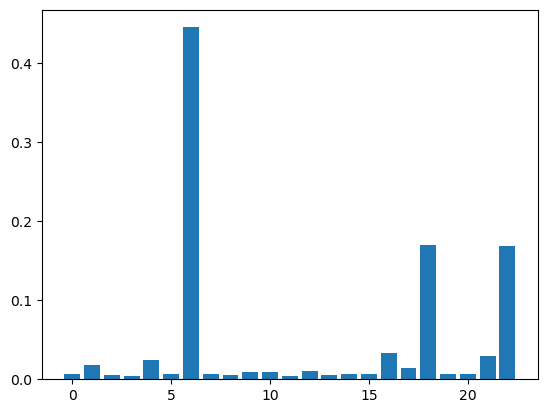

In [105]:
plt.bar(range(len(model_xg.feature_importances_)), model_xg.feature_importances_)

In [107]:
pd.DataFrame.from_dict(model_xg.get_booster().get_score(importance_type='gain'), orient="index").sort_values(by=0, ascending=False)

,0
dswrf,4.196247e+07
COS_MONTH,1.594917e+07
COS_HOUR,1.584646e+07
prate,3.160394e+06
SIN_HOUR,2.739078e+06
sde,2.313869e+06
lcc,1.672848e+06
SIN_MONTH,1.308780e+06
vis,9.440874e+05
r,8.318919e+05


Text(0.5, 0, 'Xgboost Feature Importance')

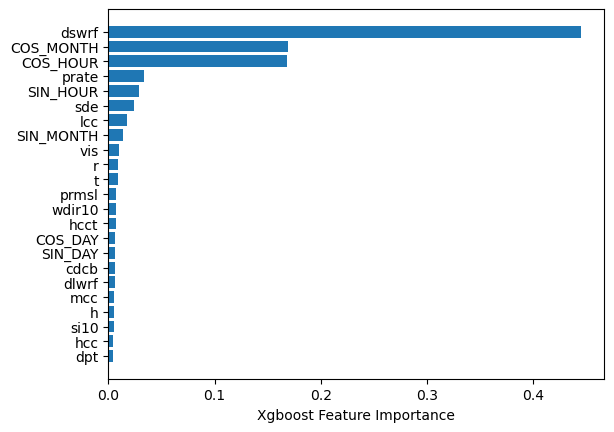

In [101]:
sorted_idx = model_xg.feature_importances_.argsort()
plt.barh(design.columns[sorted_idx], model_xg.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

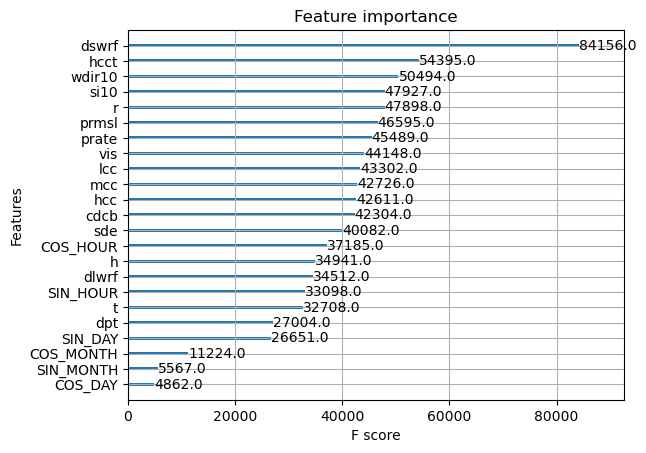

In [117]:
plot_importance(model_xg, importance_type="weight")

In [74]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

# fit a vanilla xgboost with basic hyperparameters
model_xg = XGBRegressor(**hyperparams)
model_xg.fit(X_train, y_train)

[12:51:45] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/tree/updater_prune.cc:98: tree pruning end, 698 extra nodes, 0 pruned nodes, max_depth=14
[12:51:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/tree/updater_prune.cc:98: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=19
[12:51:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/tree/updater_prune.cc:98: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=22
[12:51:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/tree/updater_prune.cc:98: tree pruning end, 808 extra nodes, 0 pruned nodes, max_depth=19
[12:51:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboost-split_1667849527992/work/src/tree/updater_prune.cc:98: tree pruning end, 688 extra nodes, 0 pruned nodes, max_depth=26
[12:51:46] INFO: /home/conda/feedstock_root/build_artifacts/xgboo

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.85,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=50, max_leaves=0, min_child_weight=20, missing=nan,
             monotone_constraints='()', n_estimators=1500, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [75]:
print(f"MSE (training/testing): {mean_squared_error(y_train, model_xg.predict(X_train)):.3f}/{mean_squared_error(y_test, model_xg.predict(X_test)):.3f}")

MSE (training/testing): 1146.044/39656.146
